In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import json
import requests
from scipy.stats import linregress
from pprint import pprint


In [2]:
# Mobility data
mobility_file = "data/2020_AU_Region_Mobility_Report.csv"
mobility_df = pd.read_csv(mobility_file)

mobility_df.head(3)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AU,Australia,NaN,NaN,NaN,NaN,NaN,ChIJ38WHZwf9KysRUhNblaFnglM,2020-02-15,4.0,3.0,-2.0,3.0,3.0,0.0
1,AU,Australia,NaN,NaN,NaN,NaN,NaN,ChIJ38WHZwf9KysRUhNblaFnglM,2020-02-16,3.0,5.0,9.0,3.0,-1.0,0.0
2,AU,Australia,NaN,NaN,NaN,NaN,NaN,ChIJ38WHZwf9KysRUhNblaFnglM,2020-02-17,-1.0,0.0,-6.0,7.0,17.0,-2.0


In [3]:
# Covid data
covid_file = "data/covid-19-all.csv"
covid_df = pd.read_csv(covid_file)

covid_df.head(3)

C:\Users\ThinkPad\anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Country/Region,Province/State,Latitude,Longitude,Confirmed,Recovered,Deaths,Date
0,NaN,NaN,NaN,NaN,51526.0,41727.0,2191.0,2021-01-01
1,NaN,NaN,NaN,NaN,58316.0,33634.0,1181.0,2021-01-01
2,NaN,NaN,NaN,NaN,99897.0,67395.0,2762.0,2021-01-01


### Cleansing Mobility data and grouping data to state level

In [4]:
# Format "Date" to datetime
mobility_df["date"]=pd.to_datetime(mobility_df["date"])

In [5]:
# Mobililty data is at sub-region_2 level. Therefore, mean or median of mobility index is calculated group by state and date
stategrp_df = mobility_df.groupby(["country_region","sub_region_1","date"])

retail_recreation = stategrp_df.retail_and_recreation_percent_change_from_baseline.median()
grocery_pharmacy = stategrp_df.grocery_and_pharmacy_percent_change_from_baseline.median()
parks = stategrp_df.parks_percent_change_from_baseline.median()
transit_stations = stategrp_df.transit_stations_percent_change_from_baseline.median()
workplaces = stategrp_df.workplaces_percent_change_from_baseline.median()
residential = stategrp_df.residential_percent_change_from_baseline.median()

# New state dataframe
state_mobility_df = pd.DataFrame({"retail_recreation_pctchange_to_baseline": retail_recreation,
                                    "grocery_pharmacy_pctchange_to_baseline": grocery_pharmacy,
                                    "parks_pctchange_to_baseline": parks,
                                    "transit_stations_pctchange_to_baseline": transit_stations,
                                    "workplaces_pctchange_to_baseline": workplaces,
                                    "residential_pctchange_to_baseline": residential
                                    }) 
#Reset index
state_mobility_df = state_mobility_df.reset_index()

#Rename columns
state_mobility_df = state_mobility_df.rename(columns={"sub_region_1":"state"})

state_mobility_df.head(3)

,country_region,state,date,retail_recreation_pctchange_to_baseline,grocery_pharmacy_pctchange_to_baseline,parks_pctchange_to_baseline,transit_stations_pctchange_to_baseline,workplaces_pctchange_to_baseline,residential_pctchange_to_baseline
0,Australia,Australian Capital Territory,2020-02-15,7.0,5.0,28.0,4.0,6.0,-1.0
1,Australia,Australian Capital Territory,2020-02-16,8.0,19.0,34.0,16.0,2.0,-2.0
2,Australia,Australian Capital Territory,2020-02-17,-1.0,10.0,9.0,21.0,25.0,-4.0


### Create & Cleasing AU Covid Dataframe

In [6]:
columns = ["Country/Region","Province/State","Latitude","Longitude","Date","Confirmed","Deaths"]

au_covid_df = covid_df.loc[covid_df["Country/Region"]=="Australia",columns]

#Reset index
au_covid_df = au_covid_df.reset_index(drop=True)

au_covid_df.head()

,Country/Region,Province/State,Latitude,Longitude,Date,Confirmed,Deaths
0,Australia,NaN,-33.8688,144.9631,2020-01-23,NaN,NaN
1,Australia,NaN,-33.8688,144.9631,2020-01-25,4.0,NaN
2,Australia,NaN,-33.8688,144.9631,2020-01-26,4.0,NaN
3,Australia,New South Wales,-33.8688,151.2093,2020-01-27,4.0,NaN
4,Australia,Victoria,-37.8136,144.9631,2020-01-27,1.0,NaN


In [7]:
# Replace n/a Covid case number with zero
au_covid_df["Confirmed"]=au_covid_df["Confirmed"].fillna(0)
au_covid_df["Deaths"]=au_covid_df["Deaths"].fillna(0)

au_covid_df.head()

,Country/Region,Province/State,Latitude,Longitude,Date,Confirmed,Deaths
0,Australia,NaN,-33.8688,144.9631,2020-01-23,0.0,0.0
1,Australia,NaN,-33.8688,144.9631,2020-01-25,4.0,0.0
2,Australia,NaN,-33.8688,144.9631,2020-01-26,4.0,0.0
3,Australia,New South Wales,-33.8688,151.2093,2020-01-27,4.0,0.0
4,Australia,Victoria,-37.8136,144.9631,2020-01-27,1.0,0.0


In [8]:
# Format "Date" to datetime
au_covid_df["Date"]=pd.to_datetime(au_covid_df["Date"])

au_covid_df.tail(3)

,Country/Region,Province/State,Latitude,Longitude,Date,Confirmed,Deaths
2593,Australia,Tasmania,-42.8821,147.3272,2020-12-31,234.0,13.0
2594,Australia,Victoria,-37.8136,144.9631,2020-12-31,20376.0,820.0
2595,Australia,Western Australia,-31.9505,115.8605,2020-12-31,861.0,9.0


In [9]:
#Rename columns
au_covid_df = au_covid_df.rename(columns={"Country/Region":"country_region", "Province/State":"state", "Date":"date"})


In [10]:
au_covid_df.head()

,country_region,state,Latitude,Longitude,date,Confirmed,Deaths
0,Australia,NaN,-33.8688,144.9631,2020-01-23,0.0,0.0
1,Australia,NaN,-33.8688,144.9631,2020-01-25,4.0,0.0
2,Australia,NaN,-33.8688,144.9631,2020-01-26,4.0,0.0
3,Australia,New South Wales,-33.8688,151.2093,2020-01-27,4.0,0.0
4,Australia,Victoria,-37.8136,144.9631,2020-01-27,1.0,0.0


### Final Working Dataframe

In [11]:
# Merge the two dataframe together with all covid data outer join 
working_df = pd.merge(au_covid_df,state_mobility_df, how="left",on=["country_region", "state", "date"])

working_df.head()

,country_region,state,Latitude,Longitude,date,Confirmed,Deaths,retail_recreation_pctchange_to_baseline,grocery_pharmacy_pctchange_to_baseline,parks_pctchange_to_baseline,transit_stations_pctchange_to_baseline,workplaces_pctchange_to_baseline,residential_pctchange_to_baseline
0,Australia,NaN,-33.8688,144.9631,2020-01-23,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Australia,NaN,-33.8688,144.9631,2020-01-25,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Australia,NaN,-33.8688,144.9631,2020-01-26,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Australia,New South Wales,-33.8688,151.2093,2020-01-27,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Australia,Victoria,-37.8136,144.9631,2020-01-27,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Mobility with N/A is considered as baseline. Therefore, update all N/A to be zero
working_df["retail_recreation_pctchange_to_baseline"]=working_df["retail_recreation_pctchange_to_baseline"].fillna(0)
working_df["grocery_pharmacy_pctchange_to_baseline"]=working_df["grocery_pharmacy_pctchange_to_baseline"].fillna(0)
working_df["parks_pctchange_to_baseline"]=working_df["parks_pctchange_to_baseline"].fillna(0)
working_df["transit_stations_pctchange_to_baseline"]=working_df["transit_stations_pctchange_to_baseline"].fillna(0)
working_df["workplaces_pctchange_to_baseline"]=working_df["workplaces_pctchange_to_baseline"].fillna(0)
working_df["residential_pctchange_to_baseline"]=working_df["residential_pctchange_to_baseline"].fillna(0)

working_df.head()

,country_region,state,Latitude,Longitude,date,Confirmed,Deaths,retail_recreation_pctchange_to_baseline,grocery_pharmacy_pctchange_to_baseline,parks_pctchange_to_baseline,transit_stations_pctchange_to_baseline,workplaces_pctchange_to_baseline,residential_pctchange_to_baseline
0,Australia,NaN,-33.8688,144.9631,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Australia,NaN,-33.8688,144.9631,2020-01-25,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Australia,NaN,-33.8688,144.9631,2020-01-26,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Australia,New South Wales,-33.8688,151.2093,2020-01-27,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Australia,Victoria,-37.8136,144.9631,2020-01-27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Arron's Section

## Kevin's Section

## Mehrdad's Sections

## Roy's Sections

## An's Section

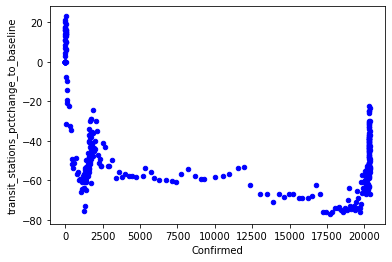

In [13]:
# reviewing the data
vic_df = working_df.loc[working_df["state"]=="Victoria",:]


vic_df.plot(kind = "scatter", x='Confirmed', y='transit_stations_pctchange_to_baseline', color="blue")
